In [4]:
import pandas as pd
import numpy as np

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [6]:
sns.set(font_scale=2.5)

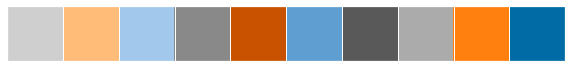

In [7]:
# using a color-blind friendly palette with 10 colors
color_blind_palette_10 = ['#cfcfcf', '#ffbc79', '#a2c8ec', '#898989', '#c85200',
                          '#5f9ed1', '#595959', '#ababab', '#ff800e', '#006ba4']

sns.palplot(color_blind_palette_10)

# Обработка данных

### Загрузка данных о фильмах:

In [8]:
movie_df = pd.read_csv('data/raw/u.item', sep='|', header=None, encoding='latin1', index_col=False,
                   names=['movie_id',
                          'movie_title',
                          'release_date',
                          'video_release_date',
                          'imdb_url',
                          'unknown',
                          'action',
                          'adventure',
                          'animation',
                          'children',
                          'comedy',
                          'crime',
                          'documentary',
                          'drama',
                          'fantasy',
                          'film_noir',
                          'horror',
                          'musical',
                          'mystery'
                          'romance',
                          'sci_fi',
                          'thriller',
                          'war',
                          'western'])

movie_df.movie_id -= 1 # make this column zero-indexed

In [9]:
movie_df.head()

,movie_id,movie_title,release_date,video_release_date,imdb_url,unknown,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,film_noir,horror,musical,mysteryromance,sci_fi,thriller,war,western
0,0,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
1,1,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,3,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
4,4,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0


### Загрузка рейтингов:

In [10]:
rating_df = pd.read_csv('data/raw/u.data', sep='\t', header=None, names=['user_id','movie_id','rating','timestamp'])
rating_df.user_id -= 1 # make this column zero-indexed
rating_df.movie_id -= 1 # make this column zero-indexed

In [11]:
rating_df.head()

,user_id,movie_id,rating,timestamp
0,195,241,3,881250949
1,185,301,3,891717742
2,21,376,1,878887116
3,243,50,2,880606923
4,165,345,1,886397596


# Будем используем только 10 фильмов с наибольшими рейтингами

In [12]:
movie_counts = rating_df.groupby('movie_id')['rating'].count().sort_values(ascending=False)

In [13]:
n_movies = 10
top_n_movies = rating_df.query('movie_id in {}'.format((movie_counts[:n_movies].index.values.tolist())))

In [14]:
# add the movie title for ease of access when plotting
# remove the timestamp column because we don't need it
top_n_movies = top_n_movies.merge(movie_df[['movie_id','movie_title']], on='movie_id', how='left') \
                           .drop(columns=['timestamp'])

In [15]:
# remove the year from the title
top_n_movies.movie_title = top_n_movies.movie_title.str.replace('\s+\(.+\)', '').str.strip()

In [16]:
top_n_movies.head()

,user_id,movie_id,rating,movie_title
0,307,0,4,Toy Story
1,250,99,4,Fargo
2,24,180,5,Return of the Jedi
3,19,287,1,Scream
4,31,293,3,Liar Liar


In [17]:
# save the output for use in other notebooks
top_n_movies.to_csv('data/top-n-movies_user-ratings.csv')

### Top N movies

In [18]:
top_n_movies.movie_title.unique().tolist()

['Toy Story',
 'Fargo',
 'Return of the Jedi',
 'Scream',
 'Liar Liar',
 'Contact',
 'English Patient, The',
 'Star Wars',
 'Independence Day',
 'Air Force One']

### Create a dictionary to map these movies to colors for consistency in plots

In [19]:
color_map = dict(zip(top_n_movies.movie_title.sort_values().unique().tolist(), color_blind_palette_10))
color_map

{'Air Force One': '#cfcfcf',
 'Contact': '#ffbc79',
 'English Patient, The': '#a2c8ec',
 'Fargo': '#898989',
 'Independence Day': '#c85200',
 'Liar Liar': '#5f9ed1',
 'Return of the Jedi': '#595959',
 'Scream': '#ababab',
 'Star Wars': '#ff800e',
 'Toy Story': '#006ba4'}

### What are the actual rating distributions of the top N movies?

In [34]:
rating_counts_by_movie = top_n_movies.groupby(['movie_id','movie_title','rating'], as_index=False).size()


In [39]:
rating_counts_by_movie.rename(columns={'size':'count'},inplace=True)

In [40]:
rating_counts_by_movie.head()

,movie_id,movie_title,rating,count
0,0,Toy Story,1,8
1,0,Toy Story,2,27
2,0,Toy Story,3,96
3,0,Toy Story,4,202
4,0,Toy Story,5,119


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


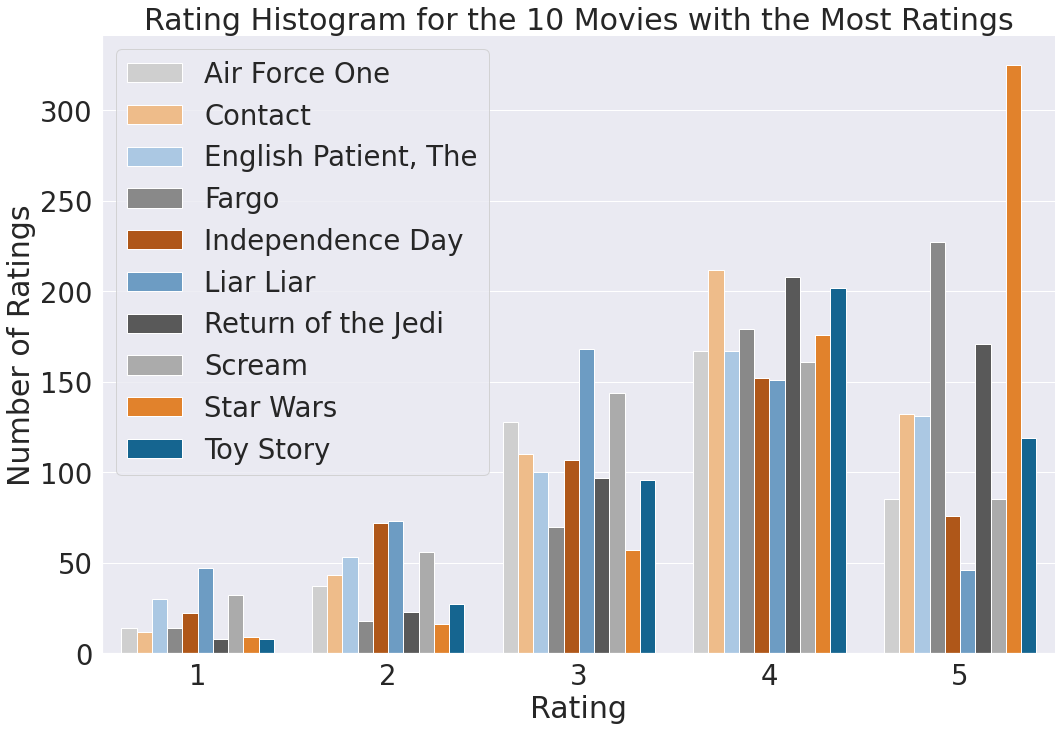

In [41]:
sns.set_palette(color_blind_palette_10)

rating_v_count_ax = sns.factorplot(data=rating_counts_by_movie, x='rating', y='count',
                                   hue='movie_title', hue_order=color_map.keys(),
                                   size=10, aspect=1.5, kind='bar', legend=False)

plt.title('Rating Histogram for the 10 Movies with the Most Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')

plt.legend(title='')

plt.show()

In [42]:
rating_v_count_ax.savefig('output/images/rating_distributions.png', transparent=False)

## Меняем рейтинги на бинарные значения 1 - "like", 0 - "dislike":

In [43]:
# movie ratings above this threshold will be counted as a "like"
reward_threshold = 4

In [44]:
rating_counts_by_movie.eval('liked = rating > @reward_threshold') \
                      .groupby(['movie_title','liked']) \
                      .sum().head()

movie_id  rating  count
movie_title          liked                         
Air Force One        False      1196      10    346
                     True        299       5     85
Contact              False      1028      10    377
                     True        257       5    132
English Patient, The False      1140      10    350

In [45]:
rating_counts_by_movie.eval('liked = rating > @reward_threshold') \
                      .groupby(['movie_title','liked'], as_index=False) \
                      .sum().head()

,movie_title,liked,movie_id,rating,count
0,Air Force One,False,1196,10,346
1,Air Force One,True,299,5,85
2,Contact,False,1028,10,377
3,Contact,True,257,5,132
4,"English Patient, The",False,1140,10,350


In [46]:
total_reward_counts = rating_counts_by_movie.eval('liked = rating > @reward_threshold') \
    .groupby(['movie_id','movie_title','liked'])['count'] \
    .sum() \
    .unstack('liked') \
    .reset_index() \
    .rename(columns={False:'disliked', True:'liked'}) \
    .eval('total = disliked + liked') \
    .eval('like_pct = 100 * liked / total')

In [47]:
total_reward_counts.sort_values('like_pct', ascending=False, inplace=True)
total_reward_counts.head(10)

liked,movie_id,movie_title,disliked,liked,total,like_pct
1,49,Star Wars,258,325,583,55.746141
2,99,Fargo,281,227,508,44.685039
4,180,Return of the Jedi,336,171,507,33.727811
6,285,"English Patient, The",350,131,481,27.234927
0,0,Toy Story,333,119,452,26.327434
5,257,Contact,377,132,509,25.933202
9,299,Air Force One,346,85,431,19.721578
7,287,Scream,393,85,478,17.782427
3,120,Independence Day,353,76,429,17.715618
8,293,Liar Liar,439,46,485,9.484536


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


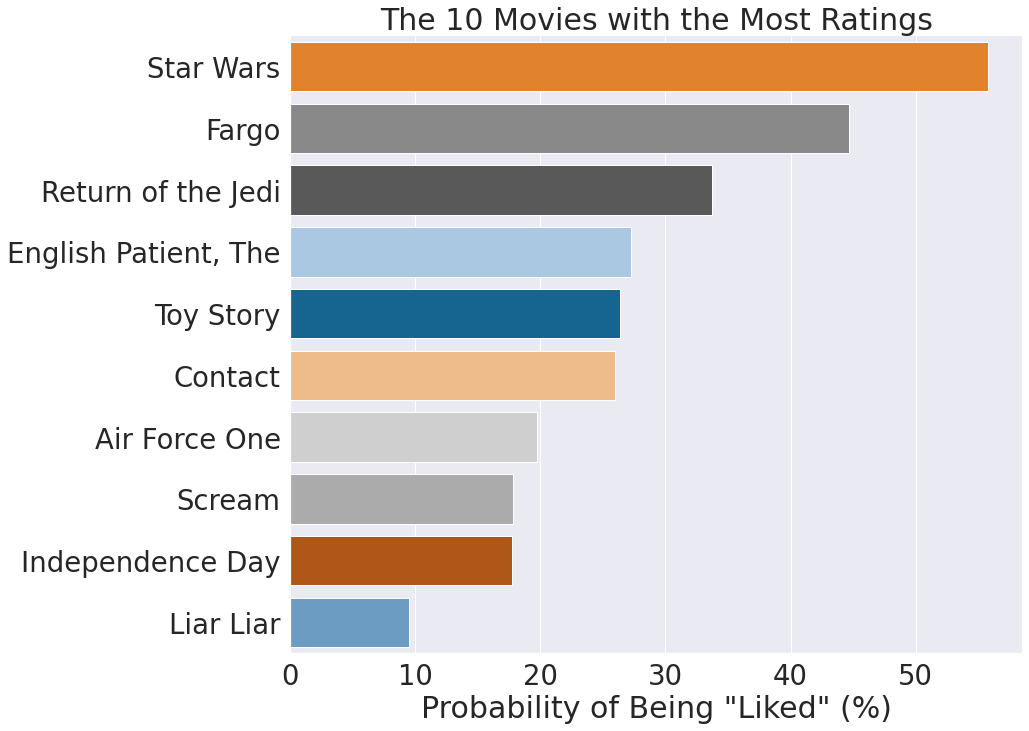

In [48]:

like_probability_ax = sns.factorplot(size=10, aspect=1.5, x='like_pct', y='movie_title', kind='bar',
                                     palette=total_reward_counts['movie_title'].apply(lambda x: color_map[x]),
                                     data=total_reward_counts)

plt.title('The 10 Movies with the Most Ratings')
like_probability_ax.set_axis_labels('Probability of Being "Liked" (%)','')

plt.show()

In [49]:
like_probability_ax.savefig('output/images/like_probabilities.png', transparent=False)